# Generate figures after Fatiando website analytics data

In [1]:
import datetime
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

## Load custom matplotlib configuration

In [2]:
plt.style.use("matplotlib.rc")

## Define paths to analytics files and to output figures directory

In [3]:
data_dir = Path("data")
active_users_file = data_dir / "fatiando-active-users.xlsx"
users_locations_file = data_dir / "fatiando-users-location.xlsx"

In [4]:
figs_dir = Path("..") / "thesis" / "figs" / "fatiando"

## Active users

In [5]:
active_users = pd.read_excel(active_users_file, sheet_name=1, index_col=0).drop(index="NaT")
active_users

/home/santi/.miniforge3/envs/phd-thesis/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,Usuarios activos en un día
Índice de día,
2017-04-01,18
2017-04-02,17
2017-04-03,28
2017-04-04,22
2017-04-05,50
...,...
2021-09-25,152
2021-09-26,76
2021-09-27,281


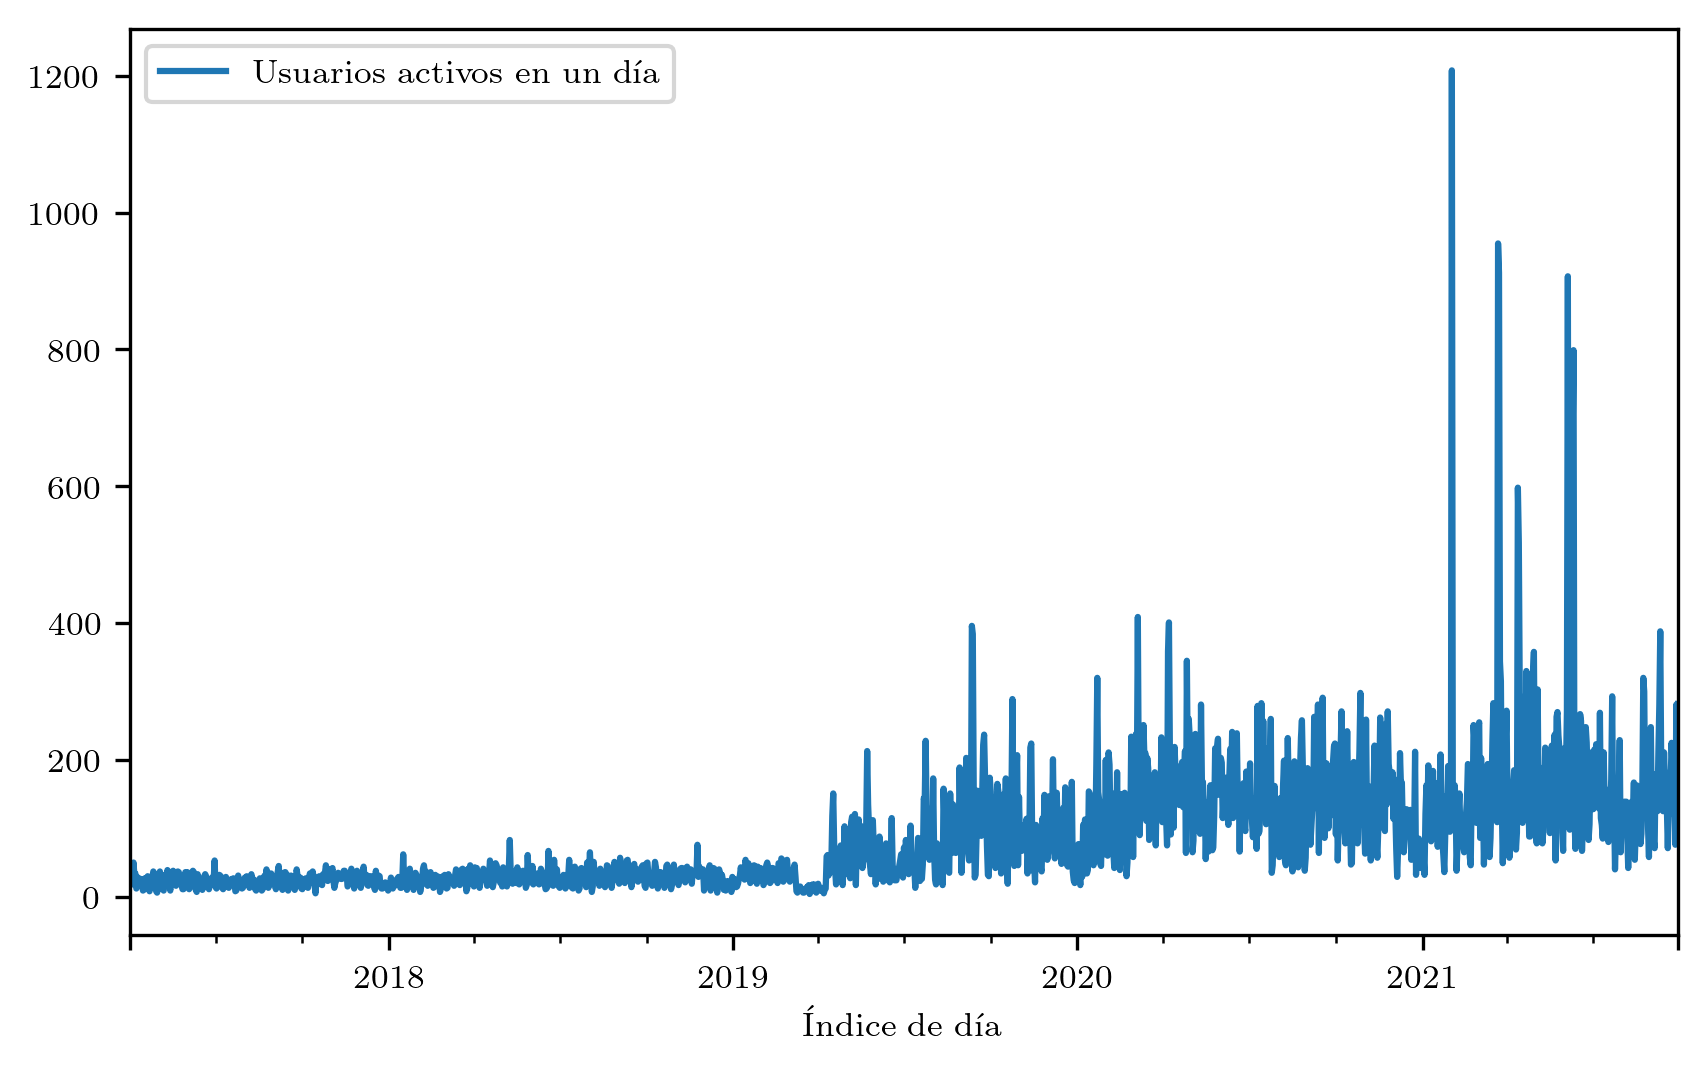

In [6]:
fig, ax = plt.subplots(figsize=(6.66, 4))
active_users.plot(ax=ax)
plt.show()

In [7]:
# Check if every day since start and end date is present in the dataframe
time_steps = active_users.index[1:] - active_users.index[:-1]
assert (time_steps == time_steps[0]).all()

In [8]:
window_size = 28
active_users_monthly = active_users.rolling(window=window_size).sum()
active_users_monthly = active_users_monthly.rename(columns={"Usuarios activos en un día": f"Usuarios activos en {window_size} días"})

In [9]:
active_users_monthly

,Usuarios activos en 28 días
Índice de día,
2017-04-01,NaN
2017-04-02,NaN
2017-04-03,NaN
2017-04-04,NaN
2017-04-05,NaN
...,...
2021-09-25,4697.0
2021-09-26,4715.0
2021-09-27,4820.0


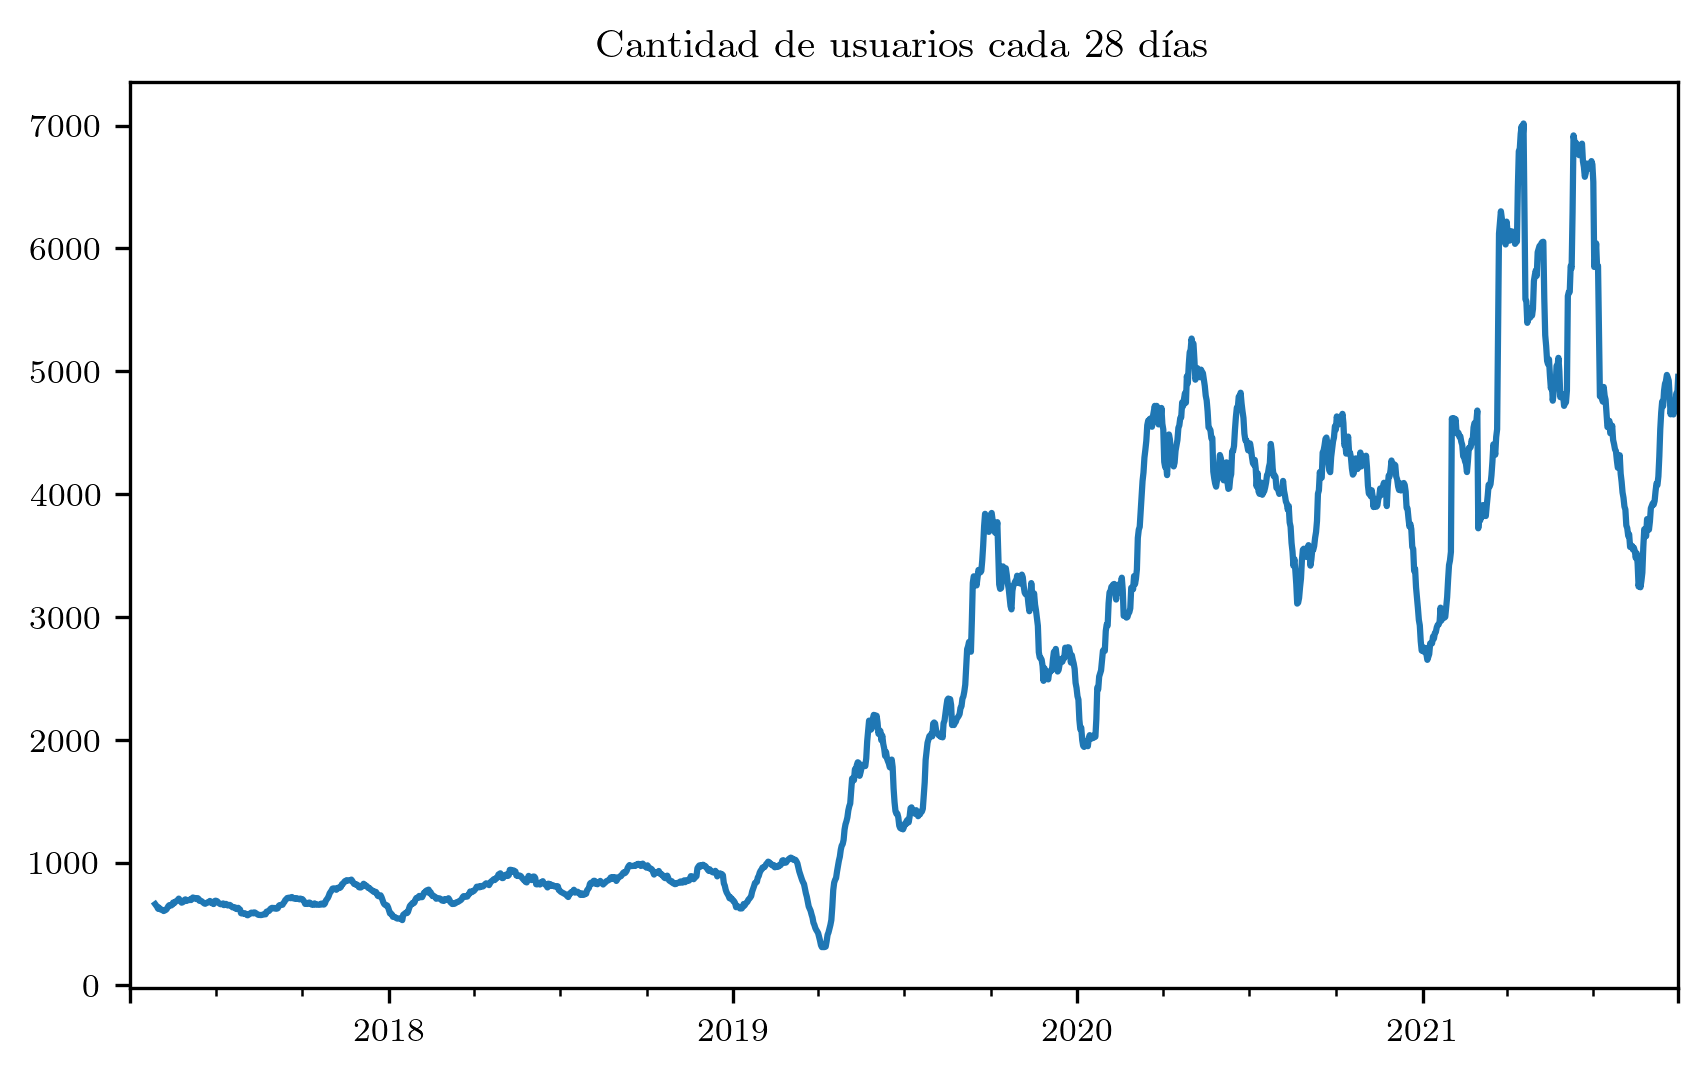

In [10]:
fig, ax = plt.subplots(figsize=(6.66, 4))
active_users_monthly.plot(ax=ax, legend=False)
ax.set_xlabel("")
plt.title("Cantidad de usuarios cada 28 días")
plt.savefig(figs_dir / "users_history.pdf")
plt.show()

## Read geographic location of users

Read the start and end date of the data

In [11]:
dates = pd.read_excel(users_locations_file, sheet_name=0).iloc[1].values[0]
start_date, end_date = [datetime.datetime.strptime(date, "%Y%m%d") for date in dates.split("-")]
print(start_date, end_date)

2017-04-01 00:00:00 2021-09-29 00:00:00


/home/santi/.miniforge3/envs/phd-thesis/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Read the geographic location of users

In [12]:
users_locations = pd.read_excel(users_locations_file, sheet_name=1, index_col=0).drop(np.nan).drop("(not set)")
users_locations = users_locations[["Usuarios"]]
users_locations

,Usuarios
País,
United States,20316
China,14498
Brazil,14093
Indonesia,8378
United Kingdom,6956
...,...
Mauritius,1
Maldives,1
Palestine,1


In [13]:
# Rename some countries to agree with the ISO codes dataframe
renamings = {
    "Antigua & Barbuda": "Antigua and Barbuda",
    "Bosnia & Herzegovina": "Bosnia and Herzegovina",
    "Congo - Brazzaville": "Congo",
    "Congo - Kinshasa": "Congo, the Democratic Republic of the",
    "Czechia": "Czech Republic",
    "Côte d’Ivoire": "Côte d'Ivoire",
    "Iran": "Iran, Islamic Republic of",
    "Laos": "Lao People's Democratic Republic",
    "Micronesia": "Micronesia, Federated States of",
    "Moldova": "Moldova, Republic of",
    "Myanmar (Burma)": "Myanmar",
    "Palestine": "Palestine, State of",
    "Svalbard & Jan Mayen": "Svalbard and Jan Mayen",
    "Syria": "Syrian Arab Republic",
    "Tanzania": "Tanzania, United Republic of",
    "Trinidad & Tobago": "Trinidad and Tobago",
}
users_locations = users_locations.rename(index=renamings)

users_locations

,Usuarios
País,
United States,20316
China,14498
Brazil,14093
Indonesia,8378
United Kingdom,6956
...,...
Mauritius,1
Maldives,1
"Palestine, State of",1


Read CSV file with the ISO_ALPHA3 code for each country

In [14]:
# Read country codes file
codes = pd.read_csv(data_dir / "countries_codes.csv")
codes

,country,code
0,Afghanistan,AFG
1,Albania,ALB
2,Algeria,DZA
3,American Samoa,ASM
4,Andorra,AND
...,...,...
254,Wallis and Futuna,WLF
255,Western Sahara,ESH
256,Yemen,YEM
257,Zambia,ZMB


Add the code column to the users locations DataFrame

In [15]:
users_locations = users_locations.merge(codes, how="left", left_on=['País'], right_on=['country'])
users_locations

,Usuarios,country,code
0,20316,United States,USA
1,14498,China,CHN
2,14093,Brazil,BRA
3,8378,Indonesia,IDN
4,6956,United Kingdom,GBR
...,...,...,...
172,1,Mauritius,MUS
173,1,Maldives,MDV
174,1,"Palestine, State of",PSE
175,1,Togo,TGO


Read shapefile with the polygons for each country

In [16]:
world = geopandas.read_file(data_dir / "ne_10m_admin_0_countries" / "ne_10m_admin_0_countries.shp")
world

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FC_TR,FC_ID,FC_PL,FC_GR,FC_IT,FC_NL,FC_SE,FC_BD,FC_UA,geometry
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4..."
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611..."
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5..."
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,0,4,China,CH1,1,2,Country,Macao S.A.R,MAC,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ..."
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,Ashmore and Cartier Islands,ATC,...,None,None,None,None,None,None,None,None,None,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4..."
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,Bajo Nuevo Bank (Petrel Is.),BJN,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796..."
256,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,Serranilla Bank,SER,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864..."


Merge the world DataFrame with the users_locations DataFrame

In [17]:
table = world.merge(users_locations, how="left", left_on=['ADM0_A3'], right_on=['code'])
table

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FC_GR,FC_IT,FC_NL,FC_SE,FC_BD,FC_UA,geometry,Usuarios,country,code
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",8378.0,Indonesia,IDN
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",489.0,Malaysia,MYS
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",868.0,Chile,CHL
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",20.0,Bolivia,BOL
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",397.0,Peru,PER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,0,4,China,CH1,1,2,Country,Macao S.A.R,MAC,...,None,None,None,None,None,None,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...",74.0,Macao,MAC
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,Ashmore and Cartier Islands,ATC,...,None,None,None,None,None,None,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4...",NaN,NaN,NaN
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,Bajo Nuevo Bank (Petrel Is.),BJN,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796...",NaN,NaN,NaN
256,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,Serranilla Bank,SER,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864...",NaN,NaN,NaN


Remove Antarctica so we don't extend the map too far south

In [18]:
table = table[table.ADMIN != "Antarctica"]
table

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,FC_GR,FC_IT,FC_NL,FC_SE,FC_BD,FC_UA,geometry,Usuarios,country,code
0,Admin-0 country,5,2,Indonesia,IDN,0,2,Sovereign country,Indonesia,IDN,...,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...",8378.0,Indonesia,IDN
1,Admin-0 country,5,3,Malaysia,MYS,0,2,Sovereign country,Malaysia,MYS,...,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...",489.0,Malaysia,MYS
2,Admin-0 country,0,2,Chile,CHL,0,2,Sovereign country,Chile,CHL,...,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...",868.0,Chile,CHL
3,Admin-0 country,0,3,Bolivia,BOL,0,2,Sovereign country,Bolivia,BOL,...,None,None,None,None,None,None,"POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...",20.0,Bolivia,BOL
4,Admin-0 country,0,2,Peru,PER,0,2,Sovereign country,Peru,PER,...,None,None,None,None,None,None,"MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...",397.0,Peru,PER
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,Admin-0 country,0,4,China,CH1,1,2,Country,Macao S.A.R,MAC,...,None,None,None,None,None,None,"MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...",74.0,Macao,MAC
254,Admin-0 country,6,5,Australia,AU1,1,2,Dependency,Ashmore and Cartier Islands,ATC,...,None,None,None,None,None,None,"POLYGON ((123.59702 -12.42832, 123.59775 -12.4...",NaN,NaN,NaN
255,Admin-0 country,6,8,Bajo Nuevo Bank (Petrel Is.),BJN,0,2,Indeterminate,Bajo Nuevo Bank (Petrel Is.),BJN,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-79.98929 15.79495, -79.98782 15.796...",NaN,NaN,NaN
256,Admin-0 country,6,5,Serranilla Bank,SER,0,2,Indeterminate,Serranilla Bank,SER,...,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,Unrecognized,"POLYGON ((-78.63707 15.86209, -78.64041 15.864...",NaN,NaN,NaN


Plot a Choropleth map of the number of visits to fatiando.org

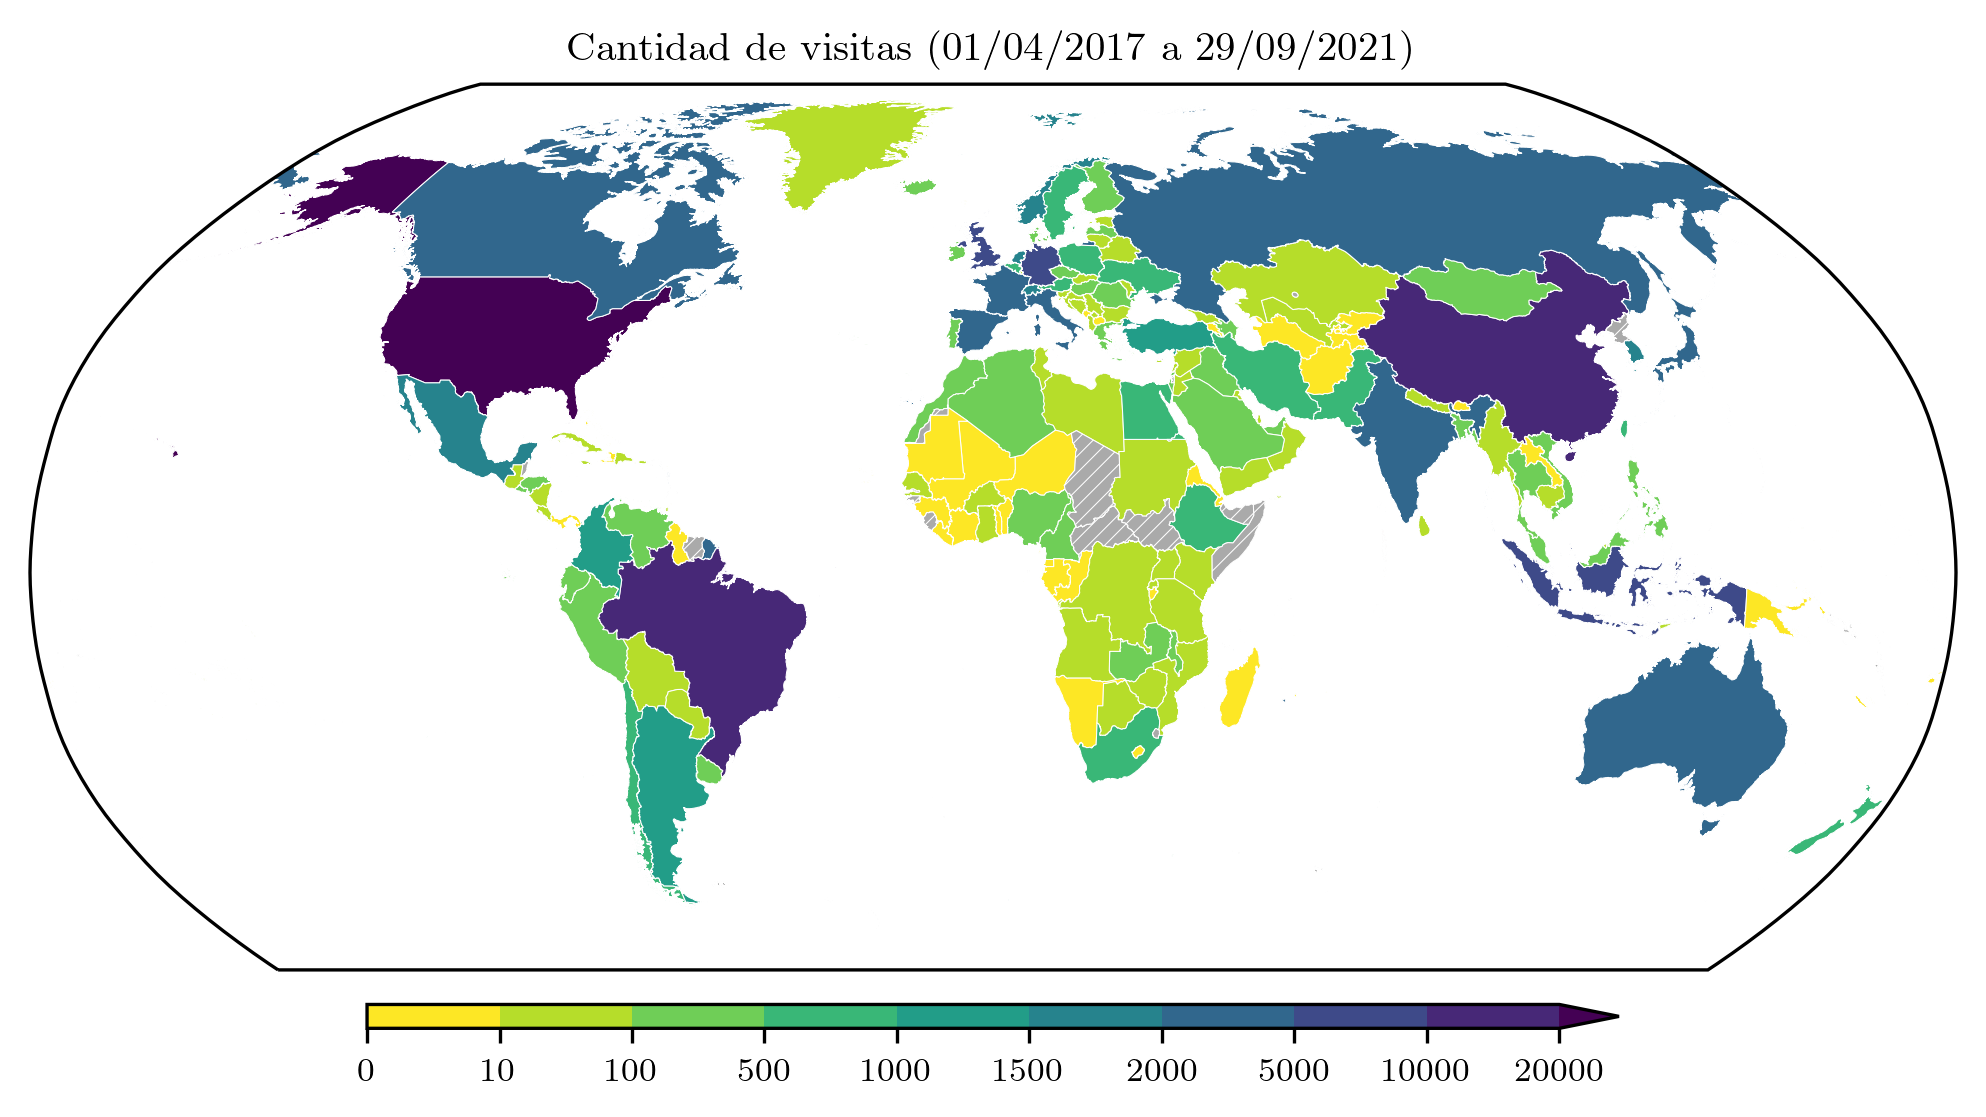

In [19]:
# Build custom colormap
vmax = np.nanmax(table.Usuarios)
boundaries = [0, 10, 100, 500, 1000, 1500, 2000, 5000, 10000, 20000, vmax]
orig_cmap = plt.cm.viridis_r
colours = orig_cmap(np.linspace(0, 1, len(boundaries)))
cmap = colors.LinearSegmentedColormap.from_list("mycmap", colours)
norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

fmt = '%d/%m/%Y'
title = f"Cantidad de visitas ({start_date.strftime(fmt)} a {end_date.strftime(fmt)})"

fig = plt.figure(figsize=(6.66, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

linewidth = 0.25

table.plot(
    column="Usuarios",
    cmap=cmap,
    norm=norm,
    linewidth=linewidth,
    edgecolor="white",
    ax=ax,
    transform=ccrs.PlateCarree(),
    missing_kwds={
        "color": "#aaa",
        "linewidth": linewidth,
        "hatch": "//////",
    },
    rasterized=True,
)
fig.colorbar(
    sm,
    boundaries=boundaries,
    extend="max",
    orientation="horizontal",
    pad=0.02,
    aspect=50,
    shrink=0.65,
)
ax.set_title(title)
ax.tick_params(
    left=False,
    bottom=False,
    labelleft=False,
    labelbottom=False,
)
plt.tight_layout()
plt.savefig(figs_dir / "users_map.pdf", bbox_inches='tight', dpi=300)
plt.show()